In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install sktime
#!pip install pmdarima
from sktime.transformations.series.impute import Imputer
import pmdarima
from sktime.forecasting.arima import AutoARIMA,ARIMA
%matplotlib inline
pd.options.mode.chained_assignment= None

### Loading Data

In [2]:
df_train_features = pd.read_csv('data/dengue_features_train.csv')
df_train_labels = pd.read_csv('data/dengue_labels_train.csv')

In [3]:
df_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


We have 19 useable features after excluding city, year, weekofyear and week_start_date. <br>
All are float type <br>
9 are related to temperature <br>
4 are related to vegetation <br>
6 are related to precipitation/humidity etc. <br>

In [4]:
df_train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1446 non-null   float64
 11  rean

### Seperating data for SJ and IQ

We have 936 data points for San Juan and only 520 data points for Iquitos.<br>
For San Juan, we have data from 1990 to 2000. <br>
For Iquitos, we have data from 2000 to 2010.

In [5]:
df_train_features_sj = df_train_features.loc[df_train_features['city']=='sj',:]
print('San Juan:')
print('Total number of examples: ',df_train_features_sj.shape[0])
print('Per year counts:\n', df_train_features_sj['year'].value_counts().sort_index())

print('Iquitos:')
df_train_features_iq = df_train_features.loc[df_train_features['city']=='iq',:]
print('\nTotal number of examples: ', df_train_features_iq.shape[0])
print('Per year counts:\n', df_train_features_iq['year'].value_counts().sort_index())

San Juan:
Total number of examples:  936
Per year counts:
 1990    35
1991    52
1992    52
1993    52
1994    52
1995    52
1996    52
1997    52
1998    52
1999    52
2000    52
2001    52
2002    52
2003    52
2004    52
2005    52
2006    52
2007    52
2008    17
Name: year, dtype: int64
Iquitos:

Total number of examples:  520
Per year counts:
 2000    26
2001    52
2002    52
2003    52
2004    52
2005    52
2006    52
2007    52
2008    52
2009    52
2010    26
Name: year, dtype: int64


### Missing Data

In [6]:
percent_missing_sj = 100*df_train_features_sj.isnull().sum()/len(df_train_features_sj)
percent_missing_iq = 100*df_train_features_iq.isnull().sum()/len(df_train_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats

,precent_missing_sj,precent_missing_iq
city,0.000000,0.000000
year,0.000000,0.000000
weekofyear,0.000000,0.000000
week_start_date,0.000000,0.000000
ndvi_ne,20.405983,0.576923
ndvi_nw,5.235043,0.576923
ndvi_se,2.029915,0.576923
ndvi_sw,2.029915,0.576923
precipitation_amt_mm,0.961538,0.769231
reanalysis_air_temp_k,0.641026,0.769231


#### 'ndvi_ne' missing for San Juan in year 1994

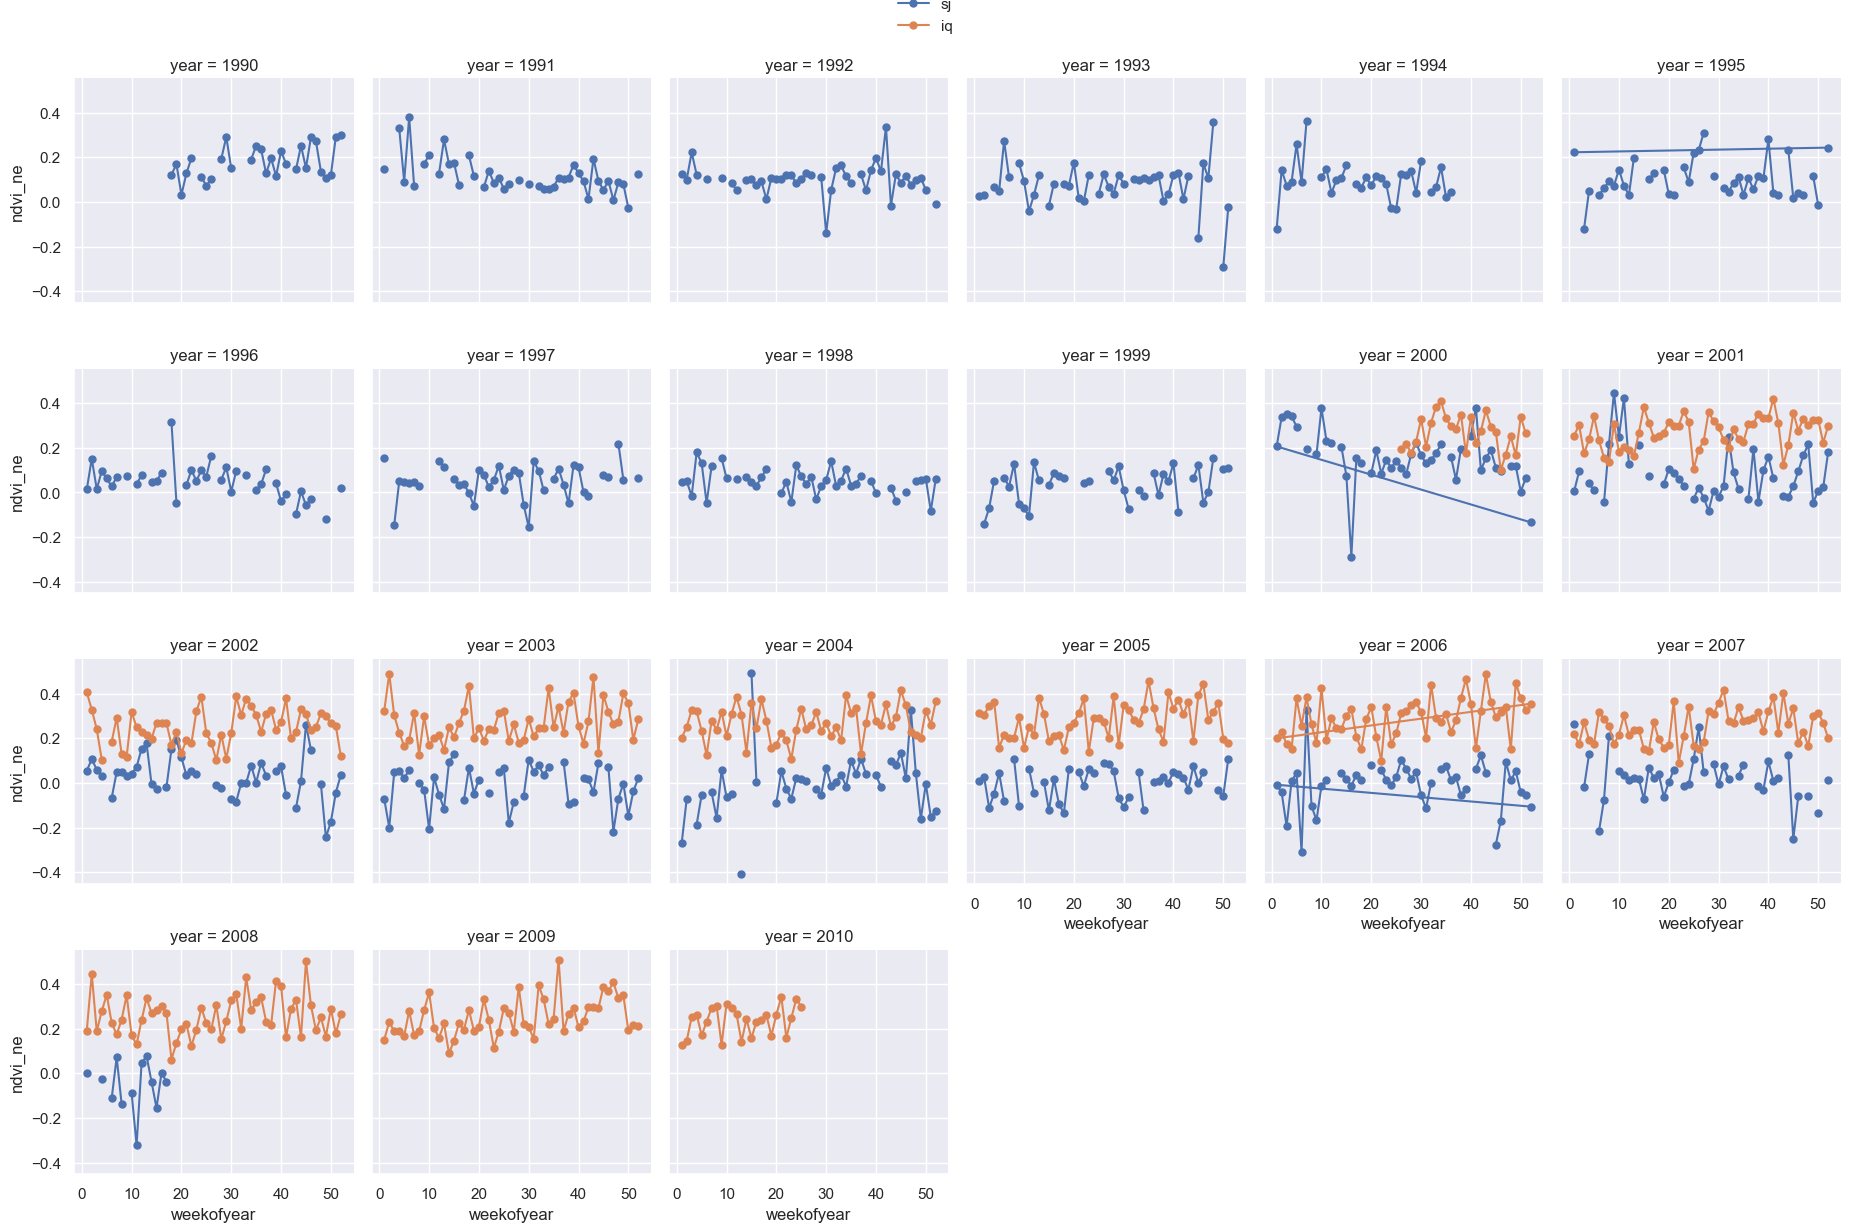

In [7]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','ndvi_ne', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

ndvi_ne has 20% missing values for SJ so we will look at that. From the graph we see that year 1994 is missing after 35th week

Text(0.5, 1.0, 'ndvi_ne for San Juan for year 1994')

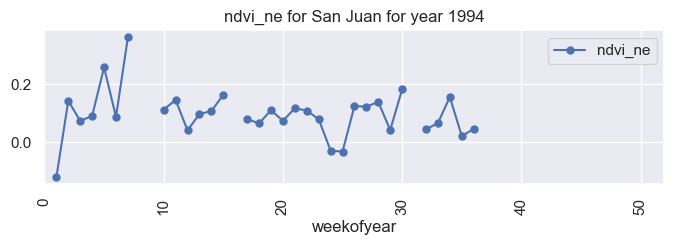

In [8]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_sj.loc[(df_train_features_sj['year']==1994),][['weekofyear','ndvi_ne']].plot(x='weekofyear',y='ndvi_ne',rot=90,marker = '.', markersize = 10)
plt.xlim((0,52))
plt.title('ndvi_ne for San Juan for year 1994')

#### 'station' fields missing for Iquitos in year 2008

station_avg_temp_c has 7% missing values for IQ so we will look at that. From the graph we see that year 2008 is the most problematic from 23rd to 30th week

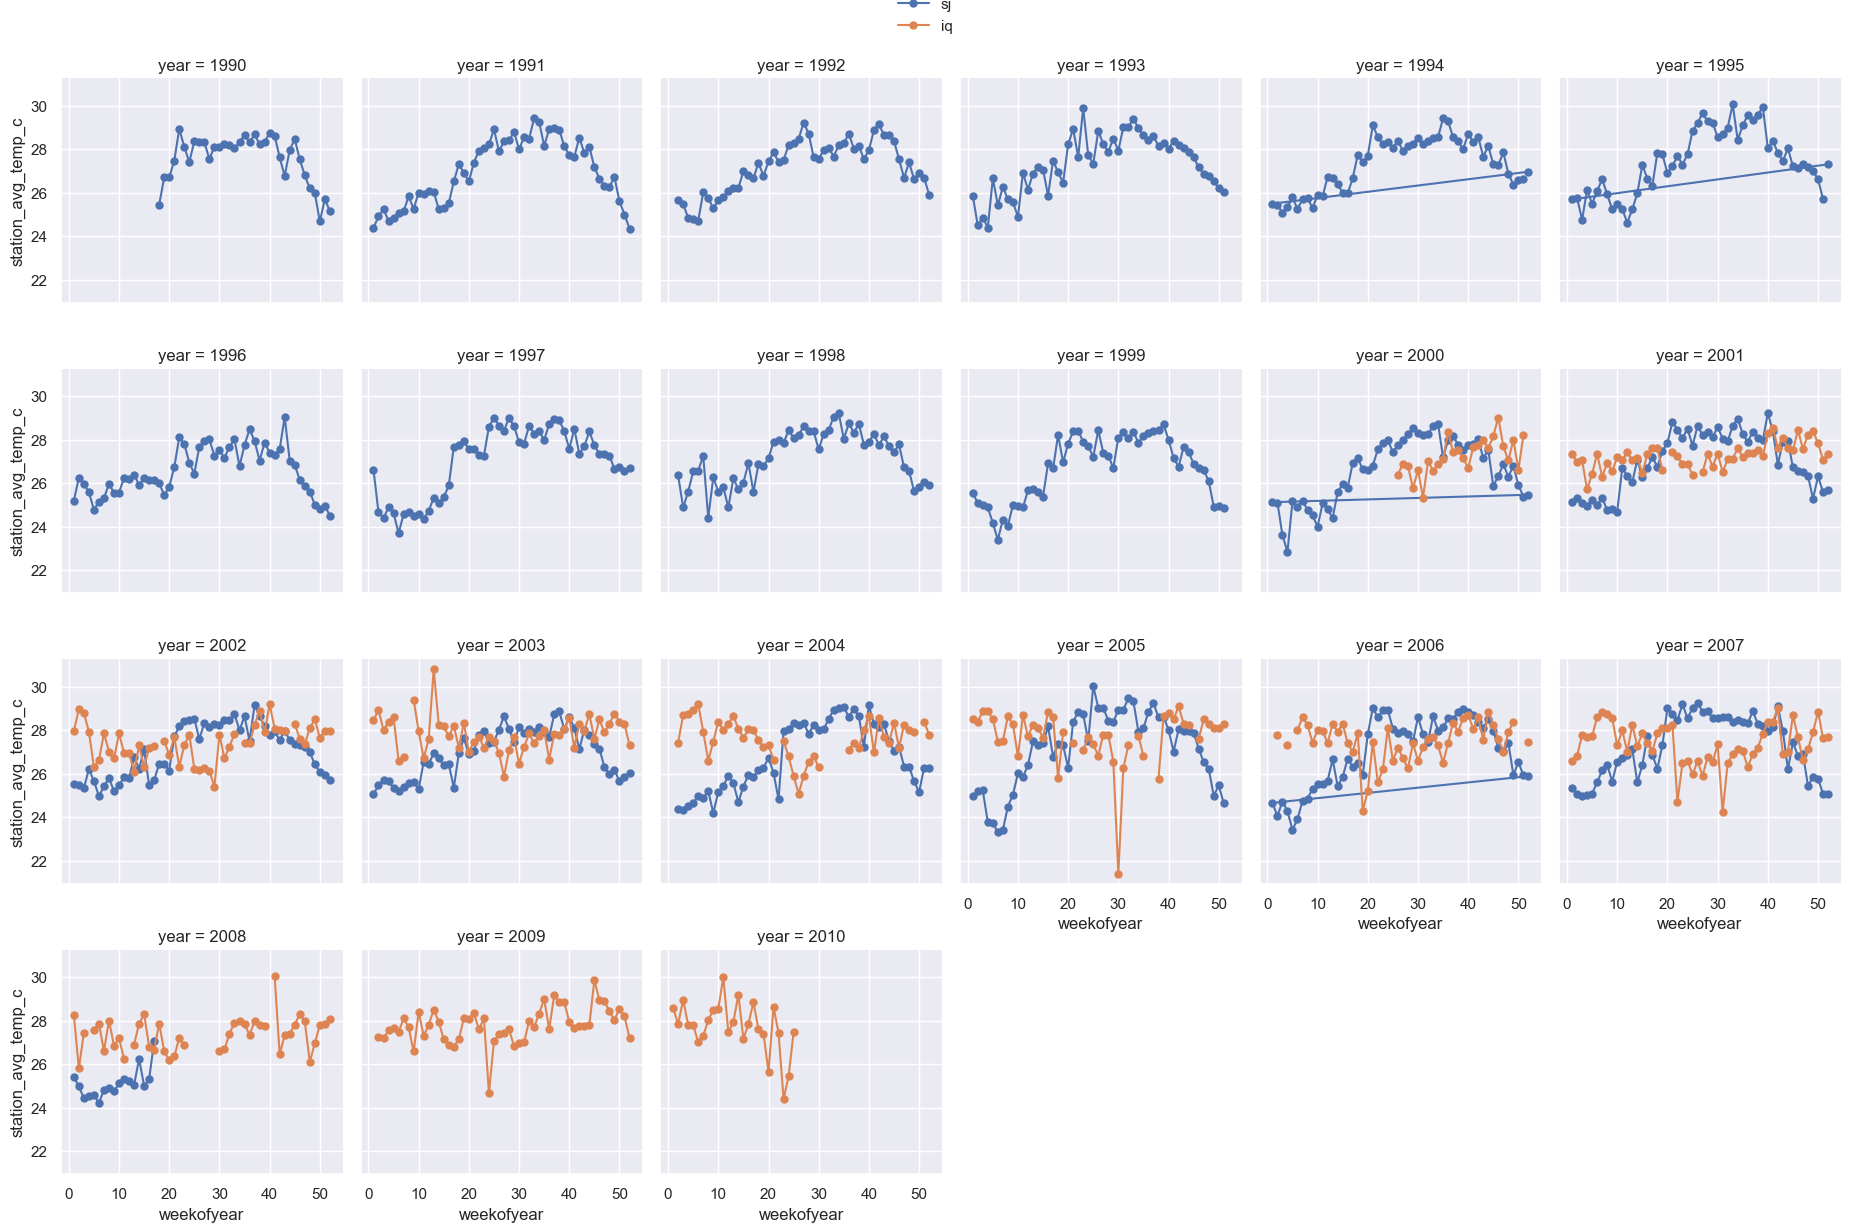

In [9]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','station_avg_temp_c', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'station_avg_temp_c for Iquitos for year 2008')

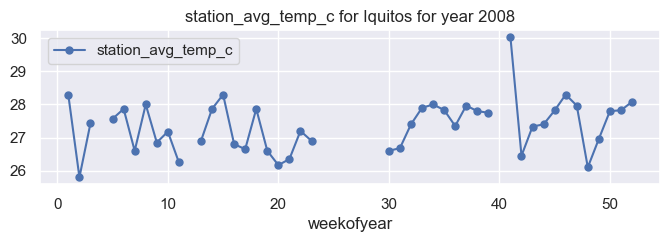

In [10]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_iq.loc[(df_train_features_iq['year']==2008),][['weekofyear','station_avg_temp_c']].plot(x='weekofyear',y='station_avg_temp_c',marker = '.', markersize = 10)
plt.title('station_avg_temp_c for Iquitos for year 2008')

### Filling in Missing Values

Filling in all values with more than 1% missing values with ARIMA forecaster. Otherwise forward fill is used 

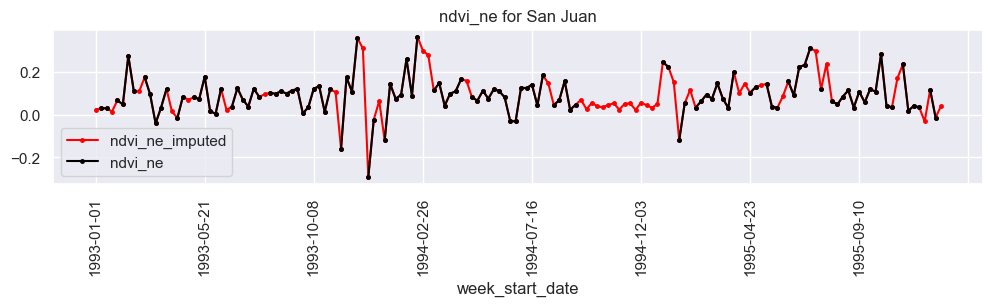

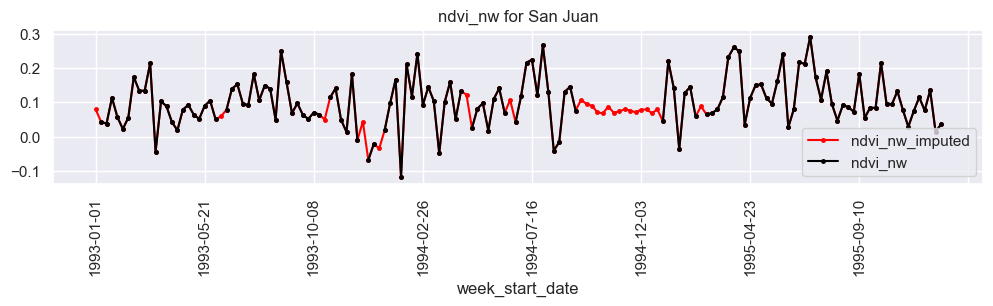

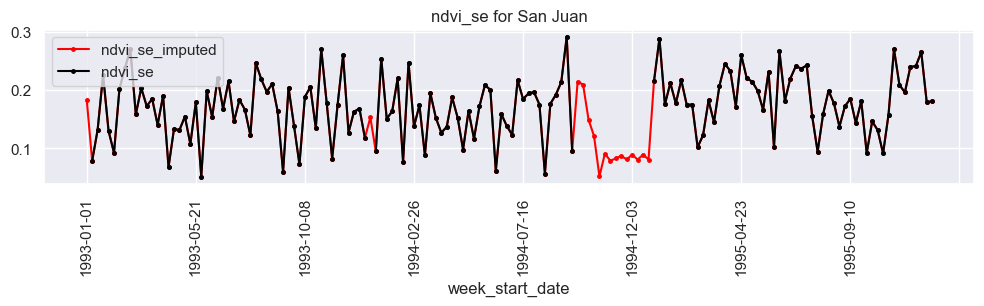

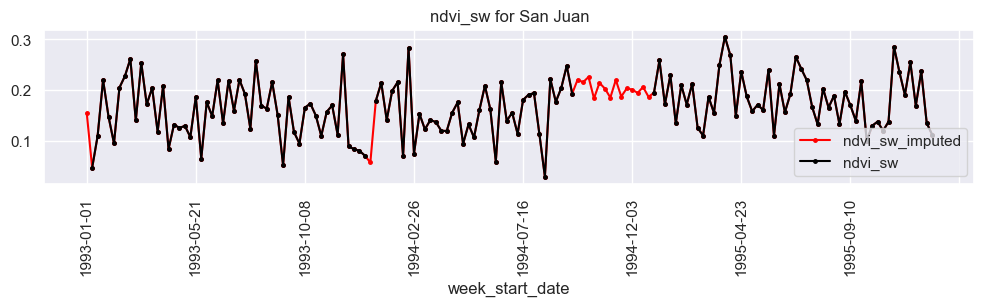

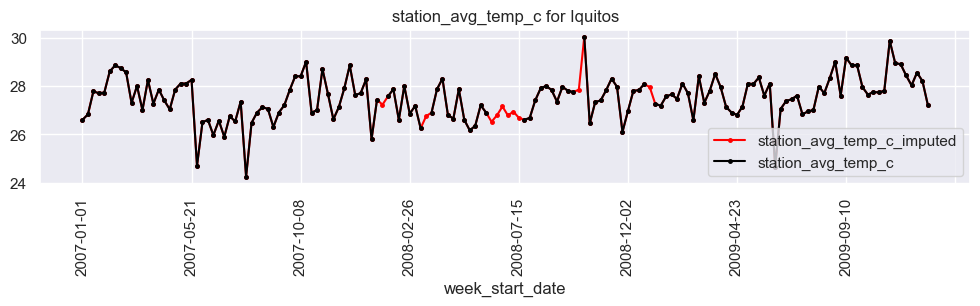

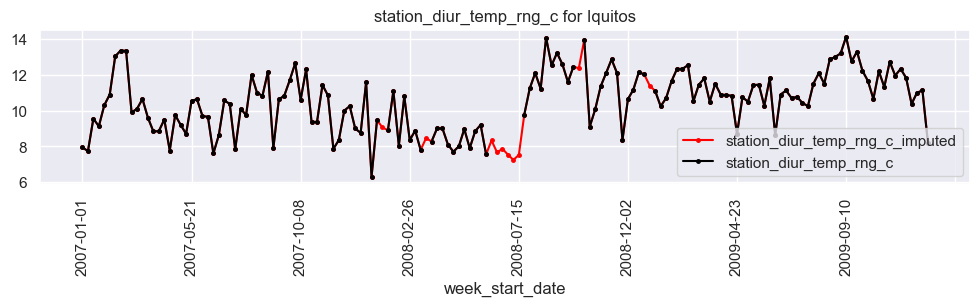

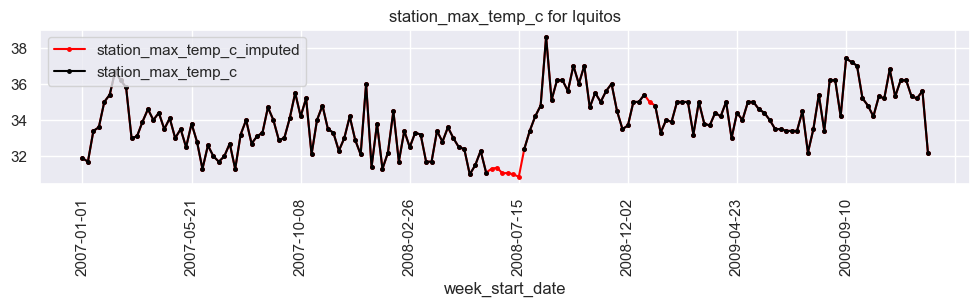

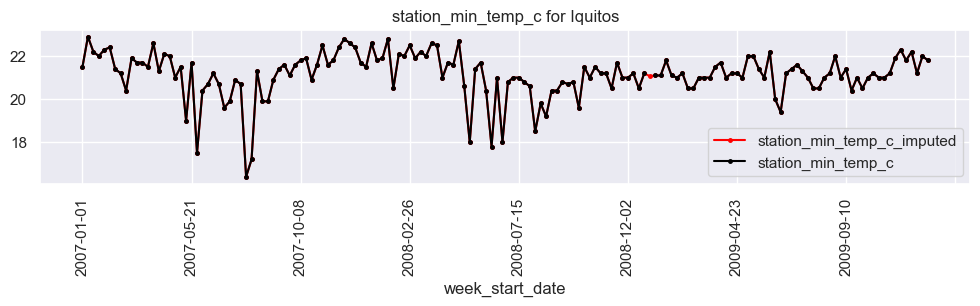

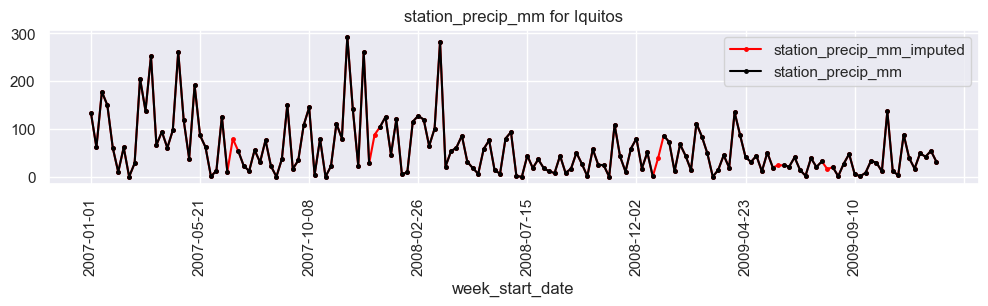

In [11]:
missing_threshold = 1
forecaster= ARIMA((7,3,7), suppress_warnings=True)

def impute(df,colname):
    for i in range(len(df.columns)):
        #SELECTING VARIABLE TO IMPUTE
        var = df_missing_stats.reset_index().iloc[i,0]
        
        #IF IT'S MISSING PERCENTAGE IS > MISSING THRESHOLD THEN USE FORECASTER
        if (df_missing_stats.reset_index().loc[i,colname] > missing_threshold):
            transformer = Imputer(method="forecaster",forecaster=forecaster) #ARIMA FORECASTER
            df.loc[:,var+'_imputed'] = transformer.fit_transform(df.loc[:,var])
            
            #PLOTTING VEGETATION FIELDS FOR SAN JUAN
            if 'ndvi' in var and 'sj' in colname :
                fig, ax = plt.subplots(figsize=(12,2));
                plt.title(var+' for San Juan')
                df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)
            
            #PLOTTING STATION FIELDS FOR IQUITOS
            if 'station' in var and 'iq' in colname :
                fig, ax = plt.subplots(figsize=(12,2));
                plt.title(var+' for Iquitos')
                df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)
            df.drop(var, axis=1,inplace=True)
        #IF MISSING % IS LESS THAN MISSING THRESHOLD THEN USE FORWARD FILL
        elif (df_missing_stats.reset_index().loc[i,colname] > 0) :
            df.loc[:,var+'_imputed'] = df_train_features_sj[var].fillna(df[var].ffill())
            df.drop(var, axis=1,inplace=True)
    return df


df_train_features_sj_imputed = impute(df_train_features_sj.copy(),'precent_missing_sj')
df_train_features_iq_imputed = impute(df_train_features_iq.copy(),'precent_missing_iq')